# **A full 3D analysis using the low-level Gammapy API**

**Objective: Performing a full 3D anaysis of the extended source [MSH 15-52](http://tevcat.uchicago.edu/?mode=1;id=95)**

In practice, we have to:
- Prepare the **data access and selection**
  - Create a `~gammapy.data.DataStore` poiting to the relevant data 
  - Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Set up the **analyis parameters**
  - Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
    - Define the exclusion mask
    - Choose the correct ~gammapy.datasets.Dataset type and define it
- Do the **data reduction**
  - Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the [background normalization](https://docs.gammapy.org/dev/user-guide/makers/fov.html) maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeMaskMaker`
  - Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Make the **modeling and fitting**
  - Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
  - Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
  - Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import numpy as np
import logging
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from scipy.stats import norm

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    Models
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator

## Optional set-up

In [4]:
logging.basicConfig()    
log = logging.getLogger("1Danalysis")
log.setLevel(logging.WARNING) #INFO, WARNING, DEBUG

from astropy.io.fits.verify import VerifyWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', VerifyWarning)

from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse, here the H.E.S.S. DL3 DR1. 

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
pos = SkyCoord(228.32083333, -59.08166667, unit=u.deg, frame="icrs")
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (228.32083333, -59.08166667)>

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [7]:
obs_table_filtered = data_store.obs_table.select_sky_circle(center=pos, radius=2 * u.deg)
obs_ids = obs_table_filtered["OBS_ID"]

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [8]:
observations = data_store.get_observations(obs_ids)

INFO:gammapy.data.data_store:Observations selected: 20 out of 20.


In [9]:
print(observations)

Observations
Number of observations: 20
Observation

	obs id            : 20136 
 	tstart            : 53090.12
	tstop             : 53090.14
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.6%
Observation

	obs id            : 20137 
 	tstart            : 53090.14
	tstop             : 53090.16
	duration          : 902.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 20151 
 	tstart            : 53091.10
	tstop             : 53091.12
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.1%
Observation

	obs id            : 20282 
 	tstart            : 53109.98
	tstop             : 53110.00
	duration          : 1687.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 8.5%
Observation

	obs id            : 20283 
 	tstart            : 53110.00
	tstop             : 53110.02
	duration          : 1683.00 s
	pointing (icrs)   :

In [10]:
obs = observations[0]

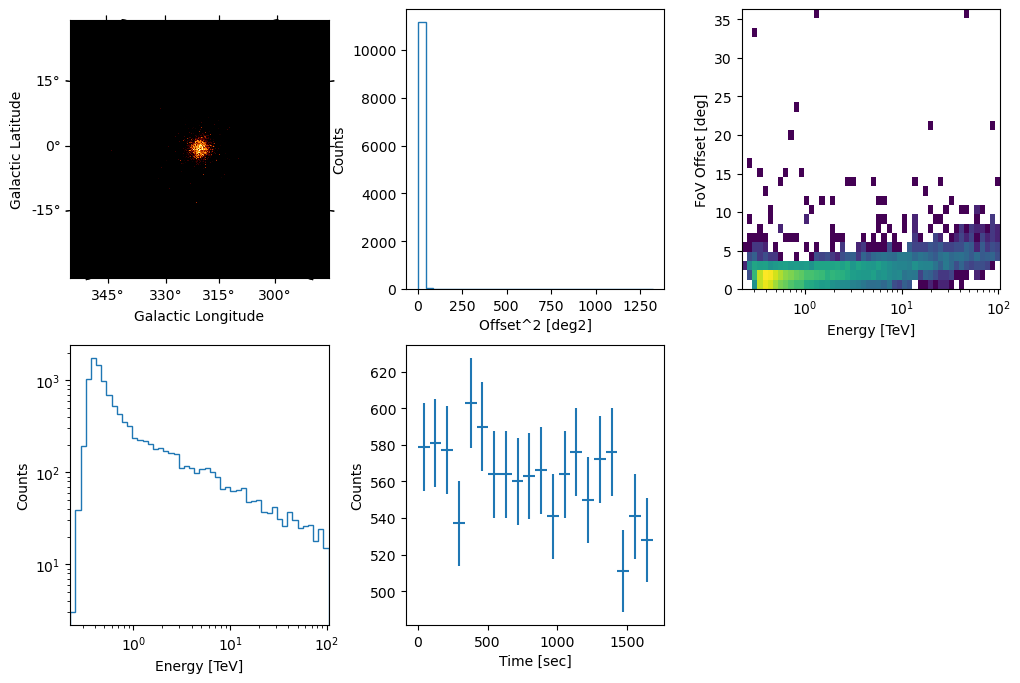

In [11]:
obs.events.peek()

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [12]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=(pos.ra.value, pos.dec.value),
    binsz=0.02,
    width=(4, 4),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

Now we can define the target dataset with this geometry.

In [13]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="msh-stacked"
)

## Data reduction

### Create the maker classes to be used

We first initialize the `Maker` objects that will take care of the data reduction.

In [14]:
offset_max = 2.0 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

In [15]:
circle = CircleSkyRegion(
    center=SkyCoord(pos.ra, pos.dec), radius=0.4 * u.deg
)
exclusion_mask = geom.region_mask(regions=[circle], inside=False)
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [16]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

### Perform the data reduction loop

In [18]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} +/- {dataset.background_model.spectral_model.norm.error:.3f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 20136: 0.99         +/- 0.017
Background norm obs 20137: 1.10         +/- 0.025
Background norm obs 20151: 0.93         +/- 0.017
Background norm obs 20282: 0.89         +/- 0.018
Background norm obs 20283: 0.80         +/- 0.015
Background norm obs 20301: 1.17         +/- 0.017
Background norm obs 20302: 1.19         +/- 0.018
Background norm obs 20303: 1.15         +/- 0.017
Background norm obs 20322: 1.28         +/- 0.018
Background norm obs 20323: 1.18         +/- 0.017
Background norm obs 20324: 1.20         +/- 0.018
Background norm obs 20325: 0.94         +/- 0.017
Background norm obs 20343: 0.93         +/- 0.017
Background norm obs 20344: 1.25         +/- 0.018
Background norm obs 20345: 1.14         +/- 0.017
Background norm obs 20346: 1.23         +/- 0.018
Background norm obs 20365: 1.24         +/- 0.018
Background norm obs 20366: 1.12         +/- 0.017
Background norm obs 20367: 1.15         +/- 0.018
Background norm obs 20368: 0.89         +/- 0.017


In [19]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 82106 
  Total background counts         : 81085.51
  Total excess counts             : 1020.49

  Predicted counts                : 81085.50
  Predicted background counts     : 81085.51
  Predicted excess counts         : nan

  Exposure min                    : 5.31e+07 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 502222 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Inspect the reduced dataset

In [20]:
stacked.counts.smooth(0.04 * u.deg).plot_interactive(
    stretch="linear", add_cbar=True
);

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

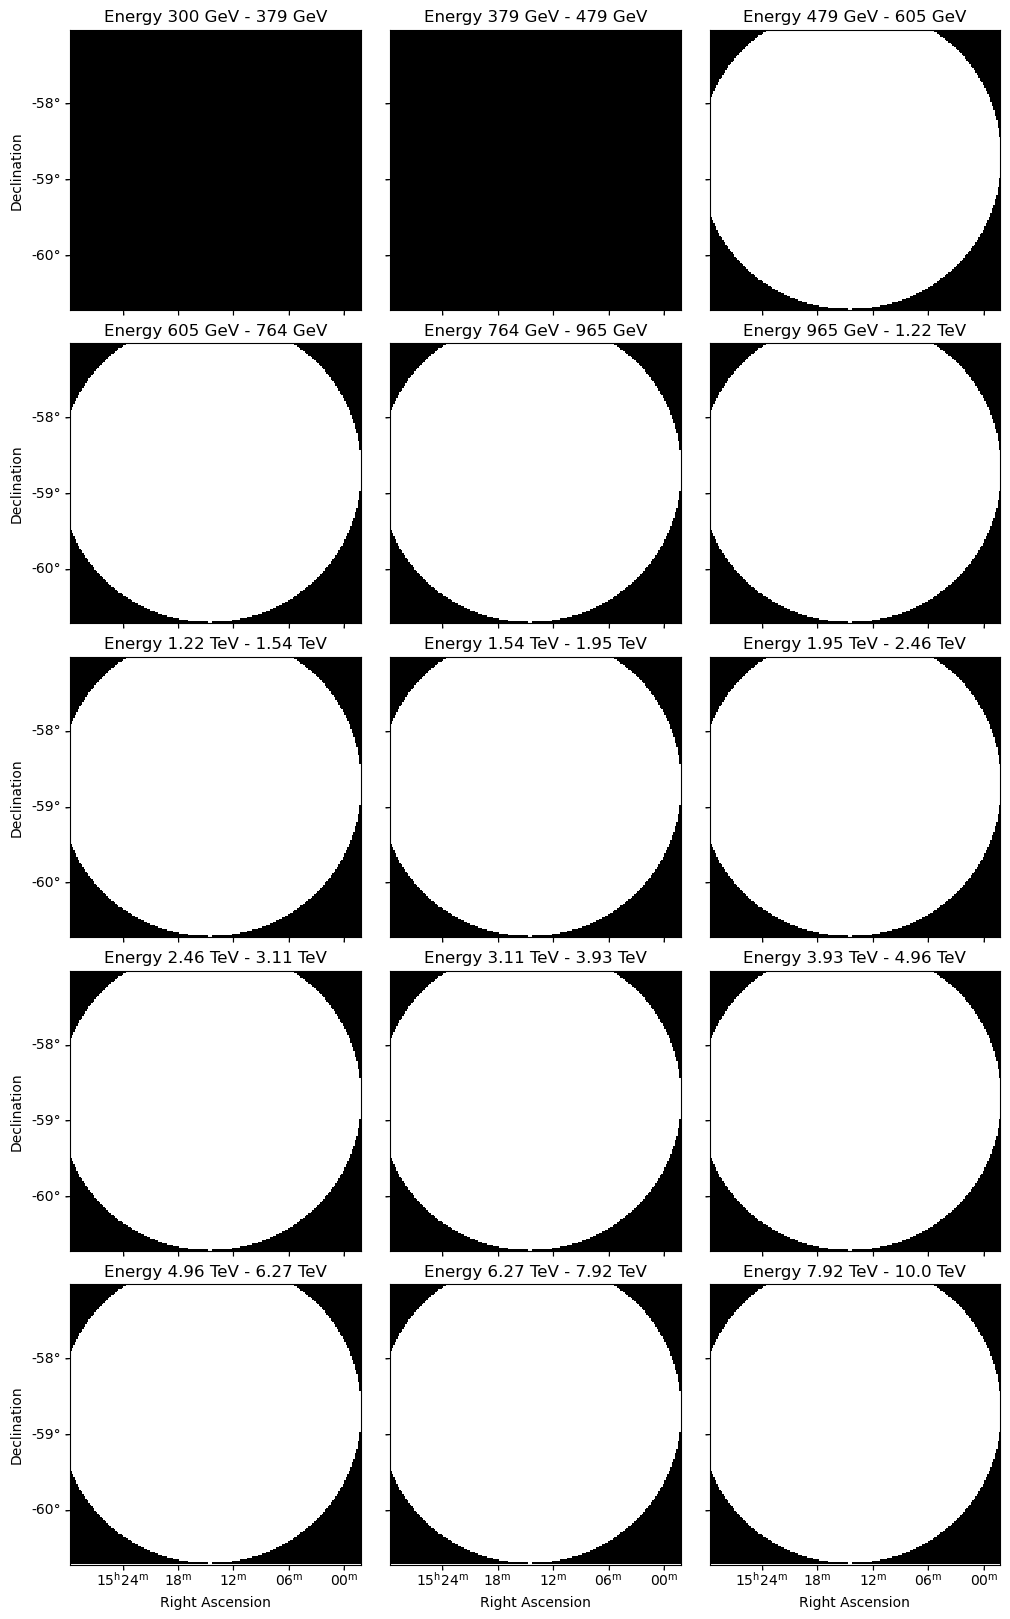

In [21]:
dataset.mask_safe.plot_grid(vmin=0, vmax=1);

Save the dataset to disc using `~gammapy.datasets.MapDataset.write()` method:

In [22]:
filename = "msh-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

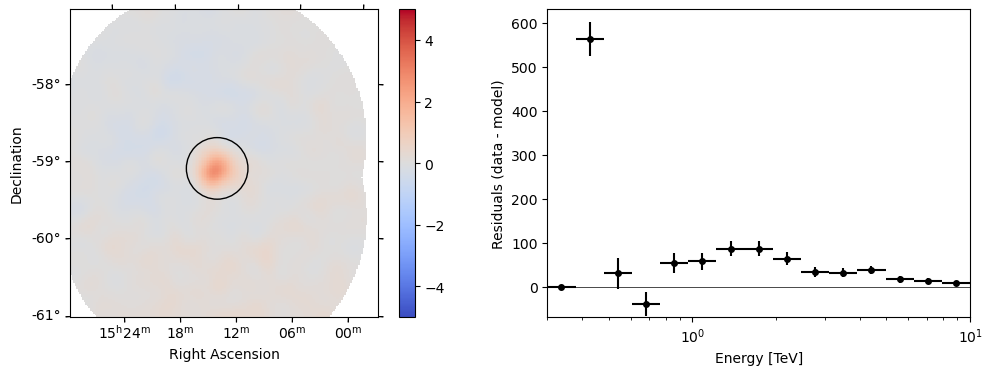

In [24]:
region = CircleSkyRegion(
    center=SkyCoord(228.5, -59.15, unit="deg"), radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region});

At this stage, we have created a DL4 `MapDataset`. The rest of the notebook is agnostic to how this dataset was created (simulated/H.E.S.S./Fermi-LAT, etc)...

If you are interested only in the spectrum, not the morphology, you can do a 1D spectral extraction using the `SpectrumDatasetMaker`. See https://docs.gammapy.org/1.0.1/tutorials/index.html#d-spectral for details.

## Compute an excess and a significance map

In [25]:
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked)

In [26]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

<WCSAxes: title={'center': 'Excess map'}>

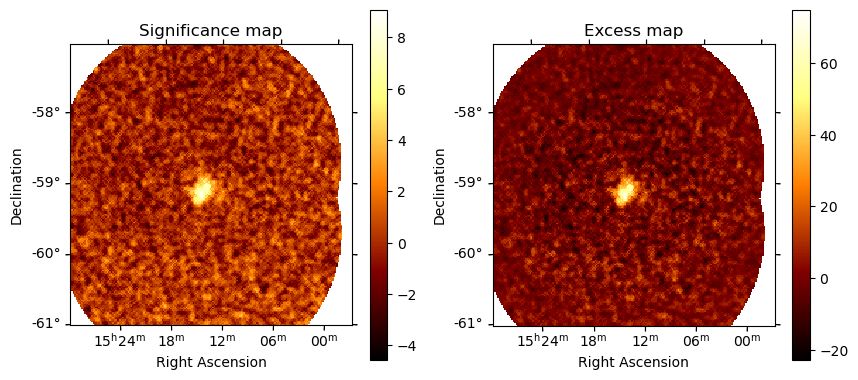

In [27]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True);

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True);

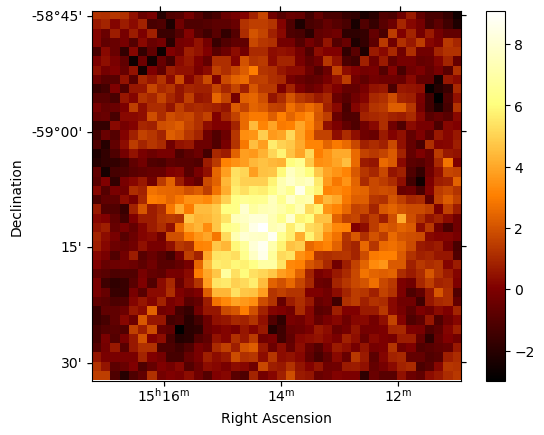

In [29]:
## You can zoom into your region
significance_map.cutout(position=SkyCoord(228.5, -59.15, unit="deg"), width=0.8*u.deg).plot(add_cbar=True);

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [30]:
spatial_model = GaussianSpatialModel(
    lon_0=pos.ra, lat_0=pos.dec, sigma=0.3*u.deg, frame="icrs"
)
# We limit the model position inside a 1 deg box centered on the reference position of MSH 15-52
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="msh"
)

Now, we define a global `~gammapy.modeling.model.FoVBackgroundModel` in order to finely adjust the level of residual CR backgroud. This should **not** be forgotten.

In [32]:
bkg_model = FoVBackgroundModel(dataset_name="msh-stacked")

Now we assign these models to our reduced dataset:

In [33]:
stacked.models = Models([sky_model, bkg_model])

In [34]:
print(stacked)

MapDataset
----------

  Name                            : msh-stacked 

  Total counts                    : 82106 
  Total background counts         : 81085.51
  Total excess counts             : 1020.49

  Predicted counts                : 89617.92
  Predicted background counts     : 81085.50
  Predicted excess counts         : 8532.42

  Exposure min                    : 5.31e+07 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 502222 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 357936.46

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : msh
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      in

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [35]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([stacked])

CPU times: user 27.6 s, sys: 757 ms, total: 28.4 s
Wall time: 28.6 s


The `FitResult` contains information about the optimization and parameter error calculation.

In [36]:
result.success

True

The fitted parameters are visible from the `~astropy.modeling.models.Models` object.

In [37]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
msh,spectral,index,2.3096e+00,,7.180e-02,nan,nan,False,False,
msh,spectral,amplitude,5.9127e-12,cm-2 s-1 TeV-1,3.529e-13,nan,nan,False,True,
msh,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
msh,spatial,lon_0,2.2854e+02,deg,1.358e-02,2.278e+02,2.288e+02,False,False,
msh,spatial,lat_0,-5.9177e+01,deg,7.176e-03,-5.958e+01,-5.858e+01,False,False,
msh,spatial,sigma,8.2913e-02,deg,5.348e-03,0.000e+00,nan,False,False,
msh,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,
msh,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,
msh-stacked-bkg,spectral,norm,9.9972e-01,,3.573e-03,nan,nan,False,True,


### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

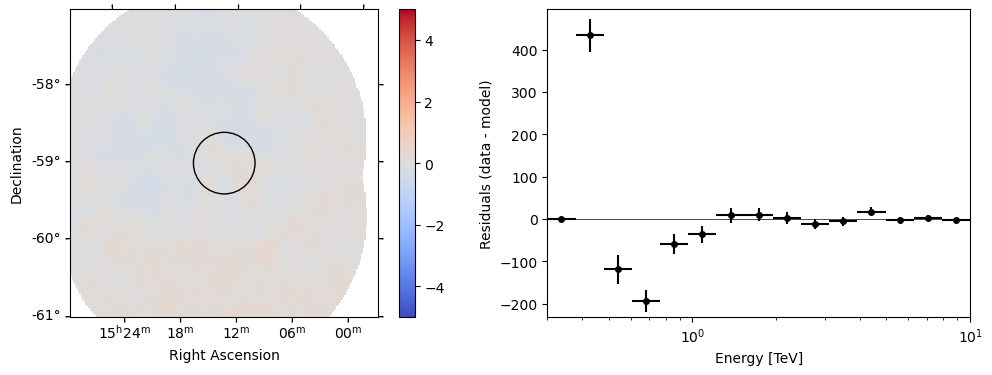

In [39]:
region = CircleSkyRegion(
    center=pos, radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region});

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:

In [40]:
spec = sky_model.spectral_model

Now we can actually do the plot using the `plot_error` method:

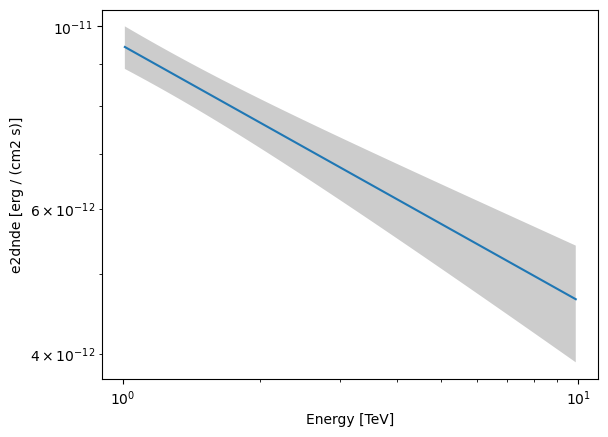

In [41]:
energy_bounds = [1, 10] * u.TeV
spec.plot(energy_bounds=energy_bounds, sed_type="e2dnde")
ax = spec.plot_error(energy_bounds=energy_bounds, sed_type="e2dnde")

### Computing flux points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [42]:
energy_edges = [0.5, 1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="msh")

In [44]:
%%time
flux_points = fpe.run(datasets=[stacked])

Energy bins:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 8.48 s, sys: 1.16 s, total: 9.64 s
Wall time: 10.4 s


<Axes: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

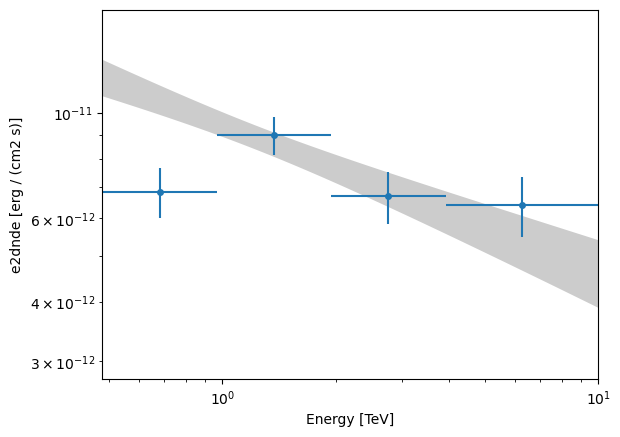

In [45]:
ax = spec.plot_error(energy_bounds=[0.3, 20] * u.TeV, sed_type="e2dnde")
flux_points.plot(ax=ax, sed_type="e2dnde");

## Dataset simulations

The standard way of running simulations consists of sampling data event-by-event and then bin them into a `Dataset` object. This is demonstrated in the tutorial https://docs.gammapy.org/1.0.1/tutorials/analysis-3d/event_sampling.html

But is it possible to directly simulate binned 3D datasets? The answer is yes. Based on the 3D dataset produced previous sections, we can generate fake datasets based on a Poisson fluctuation of the model-predicted counts and the dataset IRFs.  

The model-predicted data can be accessed through the `npred` method:

In [46]:
npred = stacked.npred()

npred.plot_interactive(
    stretch="sqrt", add_cbar=True
);

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We now create a copy of the reduced dataset, in order not to erase the real data from memory, and then call the `Dataset.fake` method to obtain a mock data realization based on the dataset `npred`.

In [47]:
# Create a dataset copy and assign the models
stacked_fake = stacked.copy(name="msh-stacked-fake")
bkg_model_fake = FoVBackgroundModel(dataset_name="msh-stacked")
stacked_fake.models = Models([sky_model, bkg_model_fake])

# Perform the binned simulation
stacked_fake.fake(random_state='random-seed')

The fake data will now be stored in the `stacked_fake.counts`.

In [48]:
stacked_fake.counts.smooth(0.04 * u.deg).plot_interactive(
    stretch="linear", add_cbar=True
);

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

# Exercises

## Beginner 
- Since MSH 1552 is a Galactic source, it can make sense to analyze it using Galactic coordinates instead of ICRS. Try to repeat the data reduction in the Galactic coordinate frame
- Modify the data reduction loop to fit also the background model `tilt` parameter, in addition to the default `norm` fit
- By default the model fit is performed in the full energy range defined by the dataset `mask_safe`. Try to restrict it by using the `Dataset.mask_fit` property
- Repeat the flux points estimation by reoptimizing, in each energy bin, all the model free parameters. This will take longer, but it will provide a more reliable estimation of the source flux in each energy bin
- What is the TS-based significance of MSH 1552? You can estimate it by comparing the model likelihood without (null hypothesis) and with the source model 

## Advanced 
- Verify that the fake data obtained in the simulation are obtained from a Poisson distribution with the `Dataset.npred` as expected value. (Hint: If this is the case, the significance of the difference between the fake data and the `Dataset.npred` has to be distributed as a standard normal Gaussian)
- Is the source extended? You can try to understand this (without any model fitting) by producing a radial flux profiles using annulus regions concentric around the source. (Tutorial reference: https://docs.gammapy.org/1.0.1/tutorials/analysis-3d/flux_profiles.html)
- Try to estimate the level of analysis systematics related to our imperfect knowledge of the IRFs. For example, what is the impact of a spectral bias in the background model with respect to the data? (Hint: A simulation-based approach can help you tackle this problem!)